## Import libraries

In [11]:
!pip3 install holidays

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.2 MB 1.4 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [86]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    accuracy_score,
    f1_score,
    recall_score
)

import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import VotingClassifier
import joblib

## Load the data

In [7]:
df = pd.read_excel("/Users/yashdoshi/Desktop/Deloitte LP/Worksheet in Case Study question 2.xlsx")
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


## Checking for duplicates

In [8]:
initial_shape = df.shape
df = df.drop_duplicates()
final_shape = df.shape
print(f"Removed {initial_shape[0] - final_shape[0]} duplicate rows.")

Removed 0 duplicate rows.


## Dealing with null values

In [9]:
df_no_null = df.copy()

# Step 2: Replace "?" with np.nan
df_no_null.replace("?", np.nan, inplace=True)
print(f"Null values in the dataset before imputation:{ df_no_null.isnull().sum().sum()}")
# Separate numeric and categorical columns
numeric_cols = df_no_null.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df_no_null.select_dtypes(include=['object']).columns

# Impute numeric columns with mean
num_imputer = SimpleImputer(strategy="mean")
df_no_null[numeric_cols] = num_imputer.fit_transform(df_no_null[numeric_cols])

# Impute categorical columns with most frequent value
cat_imputer = SimpleImputer(strategy="most_frequent")
df_no_null[categorical_cols] = cat_imputer.fit_transform(df_no_null[categorical_cols])
print(f"Null values in the dataset after imputation:{ df_no_null.isnull().sum().sum()}")

Null values in the dataset before imputation:972
Null values in the dataset after imputation:0


## Exploratory Data Analysis

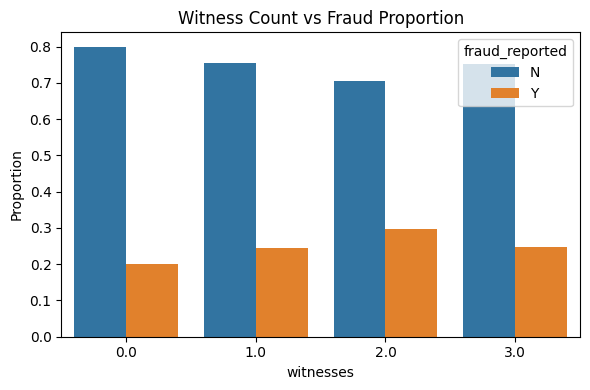

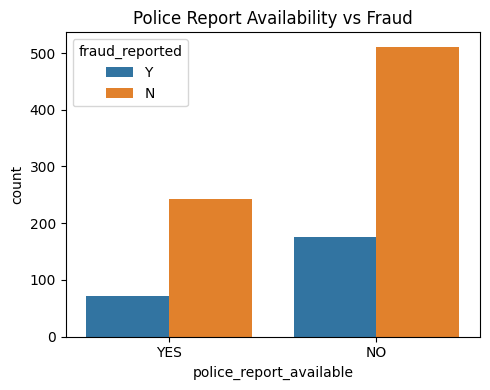

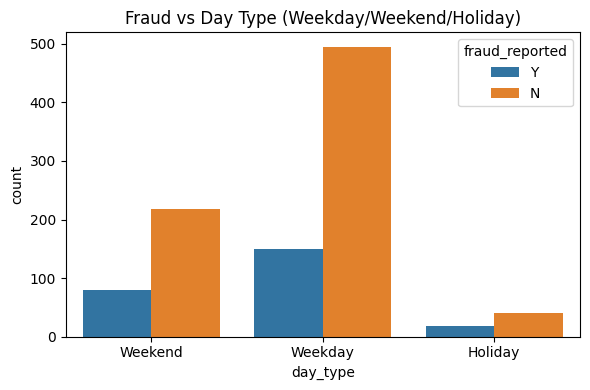

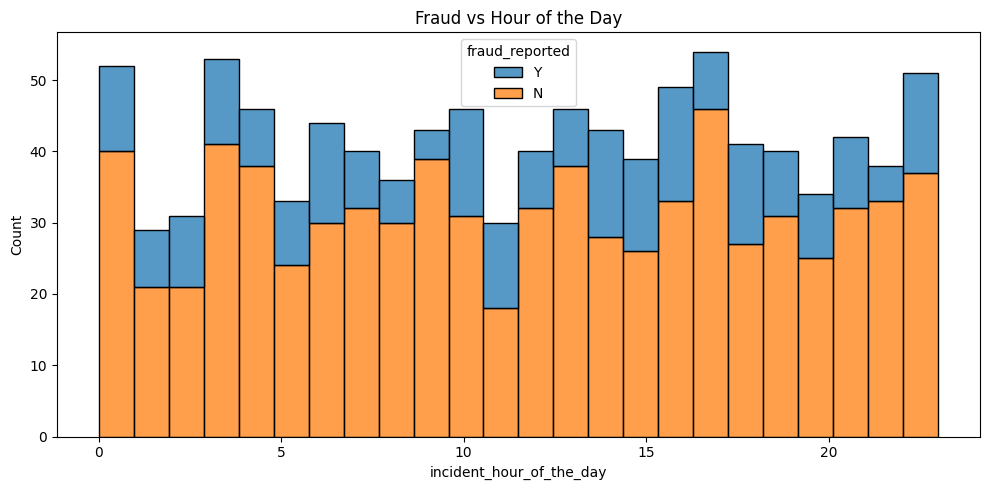

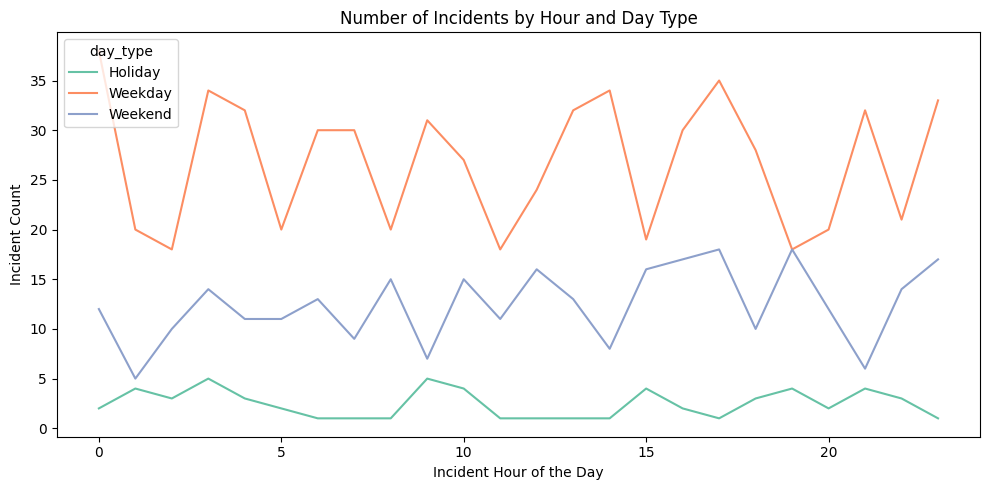

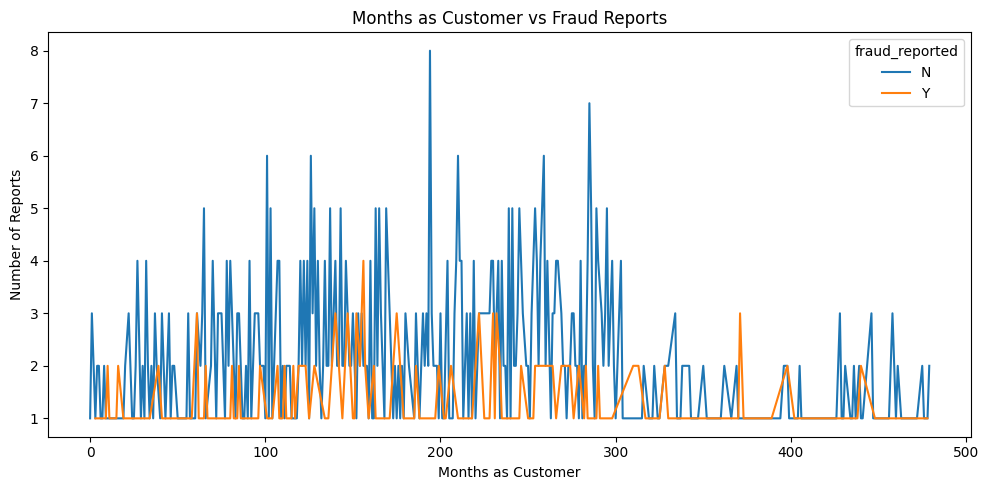


🔍 Overall fraud rate: 247/1000 = 24.70%

📊 Days Between Policy Bind and Incident (by Fraud Reported):
                 count         mean          std   min     25%     50%     75%  \
fraud_reported                                                                  
N               753.0  4737.710491  2692.065623 -20.0  2450.0  4734.0  7067.0   
Y               247.0  4743.497976  2674.616719  82.0  2525.0  4638.0  7103.0   

                   max  
fraud_reported          
N               9172.0  
Y               9124.0  

🚗 Avg Vehicle Age (by Fraud Reported):
 fraud_reported
N    9.924303
Y    9.813765
Name: vehicle_age, dtype: float64

💰 Avg Claim Amounts by Fraud Reported:
                 total_claim_amount  injury_claim  property_claim  \
fraud_reported                                                     
N                     50288.605578   7179.229748     7018.884462   
Y                     60302.105263   8208.340081     8560.121457   

                vehicle_claim  
fraud_r

In [19]:
# Parse dates
df_no_null["incident_date"] = pd.to_datetime(df_no_null["incident_date"])
df_no_null["policy_bind_date"] = pd.to_datetime(df_no_null["policy_bind_date"])

# US holiday tagging
us_holidays = holidays.US(years=[2014, 2015, 2016])
df_no_null["day_type"] = df_no_null["incident_date"].apply(
    lambda x: "Holiday" if x in us_holidays else ("Weekend" if x.weekday() >= 5 else "Weekday")
)

# Feature Engineering
df_no_null["days_between_bind_and_incident"] = (df_no_null["incident_date"] - df_no_null["policy_bind_date"]).dt.days
df_no_null["vehicle_age"] = df_no_null["incident_date"].dt.year - df_no_null["auto_year"].astype(int)

# ----------------------------- VISUALIZATIONS -----------------------------

# 1. Witnesses vs Fraud
plt.figure(figsize=(6,4))
# Calculate proportions manually
witness_fraud = df_no_null.groupby(["witnesses", "fraud_reported"]).size().reset_index(name='count')
total_per_witness = witness_fraud.groupby("witnesses")["count"].transform("sum")
witness_fraud["proportion"] = witness_fraud["count"] / total_per_witness

# Plot
sns.barplot(data=witness_fraud, x="witnesses", y="proportion", hue="fraud_reported")
plt.title("Witness Count vs Fraud Proportion")
plt.ylabel("Proportion")
plt.tight_layout()
plt.show()

# 2. Police Report Available vs Fraud
plt.figure(figsize=(5,4))
sns.countplot(data=df_no_null, x="police_report_available", hue="fraud_reported")
plt.title("Police Report Availability vs Fraud")
plt.tight_layout()
plt.show()

# 3. Fraud Distribution by Day Type
plt.figure(figsize=(6,4))
sns.countplot(data=df_no_null, x="day_type", hue="fraud_reported")
plt.title("Fraud vs Day Type (Weekday/Weekend/Holiday)")
plt.tight_layout()
plt.show()

# 4. Incident Hour vs Fraud
plt.figure(figsize=(10,5))
sns.histplot(data=df_no_null, x="incident_hour_of_the_day", hue="fraud_reported", multiple="stack", bins=24)
plt.title("Fraud vs Hour of the Day")
plt.tight_layout()
plt.show()

# 5. Incident Hour vs Day Type (Line Plot)
# Step 1: Group and count manually
incident_hour_daytype = (
    df_no_null.groupby(["day_type", "incident_hour_of_the_day"])
    .size()
    .reset_index(name="count")
)

# Step 2: Plot
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=incident_hour_daytype,
    x="incident_hour_of_the_day",
    y="count",
    hue="day_type",
    palette="Set2"
)
plt.title("Number of Incidents by Hour and Day Type")
plt.xlabel("Incident Hour of the Day")
plt.ylabel("Incident Count")
plt.tight_layout()
plt.show()

# 6. Months as Customer vs Fraud (line trend)
# Step 1: Count values
customer_fraud_counts = (
    df_no_null.groupby(["months_as_customer", "fraud_reported"])
    .size()
    .reset_index(name="count")
)

# Step 2: Plot
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=customer_fraud_counts,
    x="months_as_customer",
    y="count",
    hue="fraud_reported"
)
plt.title("Months as Customer vs Fraud Reports")
plt.xlabel("Months as Customer")
plt.ylabel("Number of Reports")
plt.tight_layout()
plt.show()

# ----------------------------- METRICS -----------------------------

# Fraud Rate Overall
total = len(df_no_null)
fraud_count = (df_no_null["fraud_reported"] == "Y").sum()
print(f"\n🔍 Overall fraud rate: {fraud_count}/{total} = {fraud_count/total:.2%}")

# Mean days between policy bind and incident for fraud vs non-fraud
days_between_stats = df_no_null.groupby("fraud_reported")["days_between_bind_and_incident"].describe()
print("\n📊 Days Between Policy Bind and Incident (by Fraud Reported):\n", days_between_stats)

# Average vehicle age for fraud vs non-fraud
vehicle_age_stats = df_no_null.groupby("fraud_reported")["vehicle_age"].mean()
print("\n🚗 Avg Vehicle Age (by Fraud Reported):\n", vehicle_age_stats)

# Claims amount by fraud
claim_stats = df_no_null.groupby("fraud_reported")[["total_claim_amount", "injury_claim", "property_claim", "vehicle_claim"]].mean()
print("\n💰 Avg Claim Amounts by Fraud Reported:\n", claim_stats)

## Feature transformation (Encoding and Scaling)

In [60]:
# Create a copy for transformation
data = df_no_null.copy()
# Identify categorical columns (excluding target)
categorical_cols = data.select_dtypes(include='object').columns.drop('fraud_reported')
cols_to_convert = ['insured_zip', 'incident_hour_of_the_day', 'auto_year']
data[cols_to_convert] = data[cols_to_convert].astype(str)
categorical_cols = list(categorical_cols) + cols_to_convert


# Convert all categorical columns to string type to ensure consistency
data[categorical_cols] = data[categorical_cols].astype(str)
# Encode target variable: 'Y' → 1, 'N' → 0
data['fraud_reported'] = data['fraud_reported'].map({'Y': 1, 'N': 0})
data.drop(columns=['incident_date', 'policy_bind_date'], inplace=True)

numerical_cols = [col for col in data.columns.values if col not in categorical_cols]

In [69]:
data_encoded = data.copy()
for col in categorical_cols:
    try:
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        transformed = encoder.fit_transform(data_encoded[[col]])
        # Get new column names
        new_cols = encoder.get_feature_names_out([col])
        df_transformed = pd.DataFrame(transformed, columns=new_cols, index=data.index)
        # Drop original column and insert new encoded columns
        data_encoded = pd.concat([data_encoded.drop(columns=[col]), df_transformed], axis=1)
    except Exception as e:
        print(f"Error encoding column {col}: {e}")

print("Encoding complete")

Encoding complete


In [70]:
# Scale all features
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data_encoded), columns=data_encoded.columns)

## Trian-test split

In [73]:
X = data_encoded.copy()
y = data_encoded['fraud_reported']
# 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Model Selection and Training

In [77]:
# 3. Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(probability=True),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "AdaBoost": AdaBoostClassifier()
}

# 4. Evaluation function
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"\n🔍 Results for: {name}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Misclassification Rate:", 1 - accuracy_score(y_test, y_pred))
    print("Sensitivity (Recall):", recall_score(y_test, y_pred))
    if y_proba is not None:
        print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# 5. Train & evaluate all models
for name, model in models.items():
    model.fit(X_train, y_train)
    evaluate_model(name, model, X_test, y_test)

/Users/yashdoshi/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



🔍 Results for: Logistic Regression
Confusion Matrix:
 [[149   2]
 [ 49   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.99      0.85       151
           1       0.00      0.00      0.00        49

    accuracy                           0.74       200
   macro avg       0.38      0.49      0.43       200
weighted avg       0.57      0.74      0.64       200

Accuracy: 0.745
F1 Score: 0.0
Misclassification Rate: 0.255
Sensitivity (Recall): 0.0
ROC AUC Score: 0.6025138532234086

🔍 Results for: Support Vector Machine
Confusion Matrix:
 [[151   0]
 [ 49   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      1.00      0.86       151
           1       0.00      0.00      0.00        49

    accuracy                           0.76       200
   macro avg       0.38      0.50      0.43       200
weighted avg       0.57      0.76      0.65       200

Accuracy: 0.755
F1 

/Users/yashdoshi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yashdoshi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yashdoshi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",


🔍 Results for: Random Forest
Confusion Matrix:
 [[151   0]
 [  9  40]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       151
           1       1.00      0.82      0.90        49

    accuracy                           0.95       200
   macro avg       0.97      0.91      0.93       200
weighted avg       0.96      0.95      0.95       200

Accuracy: 0.955
F1 Score: 0.898876404494382
Misclassification Rate: 0.04500000000000004
Sensitivity (Recall): 0.8163265306122449
ROC AUC Score: 0.9970266252196243


/Users/yashdoshi/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [21:32:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔍 Results for: XGBoost
Confusion Matrix:
 [[151   0]
 [  0  49]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00        49

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Accuracy: 1.0
F1 Score: 1.0
Misclassification Rate: 0.0
Sensitivity (Recall): 1.0
ROC AUC Score: 1.0

🔍 Results for: AdaBoost
Confusion Matrix:
 [[151   0]
 [  0  49]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00        49

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Accuracy: 1.0
F1 Score: 1.0
Misclassification Rate: 0.0
Sensitiv

## Hyper-parameter tuning of top 3 models

In [81]:
# 1. Random Forest tuning
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_cv = RandomizedSearchCV(rf, rf_params, cv=3, n_iter=10, scoring='f1', n_jobs=-1, random_state=42)
rf_cv.fit(X_train, y_train)
print("✅ Best RF Params:", rf_cv.best_params_)

# 2. XGBoost tuning
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}
xgb_cv = RandomizedSearchCV(xgb, xgb_params, cv=3, n_iter=10, scoring='f1', n_jobs=-1, random_state=42)
xgb_cv.fit(X_train, y_train)
print("✅ Best XGB Params:", xgb_cv.best_params_)

# 3. AdaBoost tuning
ada = AdaBoostClassifier()
ada_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}
ada_cv = RandomizedSearchCV(ada, ada_params, cv=3, n_iter=10, scoring='f1', n_jobs=-1, random_state=42)
ada_cv.fit(X_train, y_train)
print("✅ Best Ada Params:", ada_cv.best_params_)

✅ Best RF Params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}


/Users/yashdoshi/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [21:38:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yashdoshi/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [21:38:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yashdoshi/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [21:38:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yashdoshi/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [21:38:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warni

✅ Best XGB Params: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}
✅ Best Ada Params: {'n_estimators': 50, 'learning_rate': 0.01}


## Train on best parameters and build ensemble

In [82]:
# Use best estimators from CV
best_rf = rf_cv.best_estimator_
best_xgb = xgb_cv.best_estimator_
best_ada = ada_cv.best_estimator_

# Fit all models (refit not needed if already fitted)
best_rf.fit(X_train, y_train)
best_xgb.fit(X_train, y_train)
best_ada.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.01)

In [84]:
voting_clf = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('ada', best_ada)
    ],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=30,
                                                     n_estimators=300,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=N...
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('ada', AdaBoostClassifier(learning_rate=0.01))])

In [85]:
evaluate_model("Hard Voting Classifier", voting_clf, X_test, y_test)


🔍 Results for: Hard Voting Classifier
Confusion Matrix:
 [[151   0]
 [  0  49]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00        49

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Accuracy: 1.0
F1 Score: 1.0
Misclassification Rate: 0.0
Sensitivity (Recall): 1.0


## Exporting the trained model

In [87]:
# 1. Save the final trained ensemble model (e.g. VotingClassifier)
joblib.dump(voting_clf, "fraud_detection_voting_model.pkl")

# 2. Save the fitted scaler (StandardScaler)
joblib.dump(scaler, "scaler.pkl")

# 3. Save the fitted OneHotEncoder
joblib.dump(encoder, "encoder.pkl")

['encoder.pkl']

In [91]:
# Assuming `encoder` is already fitted
feature_names = encoder.get_feature_names_out(input_features=encoder.feature_names_in_)

# Save the feature names as a list
joblib.dump(feature_names, "encoded_feature_names.pkl")

['encoded_feature_names.pkl']

In [90]:
for col in df.columns.values:
    if df[col].dtype == 'object':
        print(f"Unique values in {col}: {df[col].unique()}")

Unique values in policy_state: ['OH' 'IN' 'IL']
Unique values in policy_csl: ['250/500' '100/300' '500/1000']
Unique values in insured_sex: ['MALE' 'FEMALE']
Unique values in insured_education_level: ['MD' 'PhD' 'Associate' 'Masters' 'High School' 'College' 'JD']
Unique values in insured_occupation: ['craft-repair' 'machine-op-inspct' 'sales' 'armed-forces' 'tech-support'
 'prof-specialty' 'other-service' 'priv-house-serv' 'exec-managerial'
 'protective-serv' 'transport-moving' 'handlers-cleaners' 'adm-clerical'
 'farming-fishing']
Unique values in insured_hobbies: ['sleeping' 'reading' 'board-games' 'bungie-jumping' 'base-jumping' 'golf'
 'camping' 'dancing' 'skydiving' 'movies' 'hiking' 'yachting' 'paintball'
 'chess' 'kayaking' 'polo' 'basketball' 'video-games' 'cross-fit'
 'exercise']
Unique values in insured_relationship: ['husband' 'other-relative' 'own-child' 'unmarried' 'wife' 'not-in-family']
Unique values in incident_type: ['Single Vehicle Collision' 'Vehicle Theft' 'Multi-ve